# Logistic Regression

In this notebook, we train Logistic Regression models to predict dry (0) or wet (1) for a given HJ Andrews River Site on a given date. 

We experiment with the following train-test-splitting strategies:
- Random
- Temporal
- Site-based

At the bottom of the notebook, we provide a function for practitioners to run inference with our trained models for an inputted site-date combination.

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

## Data Preprocessing

In [2]:
#Load drivers dataset as CSV
drivers = pd.read_csv("/Users/michaelmurphy/Desktop/usgs_data/drivers_xgb.csv")

In [4]:
#Loads obs data
data = pd.read_parquet('/Users/michaelmurphy/Desktop/usgs_data/obs.parquet')

In [5]:
#Isolate the target variable by creating dictionary of all metrics and choosing 'value'
dfs = {val: data[data['variable'] == val] for val in data['variable'].unique()}

wet_dry_df = dfs['HoboWetDry0.05']

In [7]:
#Load in remaining datasets
static_df = pd.read_parquet('/Users/michaelmurphy/Desktop/usgs_data/static_vars.parquet')
degrees = pd.read_parquet('/Users/michaelmurphy/Desktop/usgs_data/degrees.parquet')

In [8]:
#Make sure all NHD IDs are strings, normalize before merging
wet_dry_df = wet_dry_df.copy()
wet_dry_df['NHDPlusID'] = wet_dry_df['NHDPlusID'].astype(str)
drivers['NHDPlusID'] = drivers['NHDPlusID'].astype(str)
static_df['NHDPlusID'] = static_df['NHDPlusID'].astype(str)

#Make sure all date values are in datetime format, normalize before merging
wet_dry_df['Date'] = pd.to_datetime(wet_dry_df['Date'])
drivers['Date'] = pd.to_datetime(drivers['Date'])

static_df_pivot = static_df.pivot(
    index='NHDPlusID',
    columns='variable',
    values='value'
).reset_index()

#Merge all datasets to create one central dataset
central_df = wet_dry_df.merge(drivers, on=['NHDPlusID', 'Date'], how='inner')
central_df = central_df.merge(static_df_pivot, on='NHDPlusID', how='left')
central_df = central_df.merge(degrees, on='NHDPlusID', how='left')

In [9]:
#Sort by date within each NHDPlusID
central_df = central_df.sort_values(['NHDPlusID', 'Date'])

#Introduce lag by shifting the label back
#EXPERIMENT WITH THIS VALUE (which is currently -7)
central_df['wet_dry_next'] = central_df.groupby('NHDPlusID')['value'].shift(-7)

#Drop all null values
central_df = central_df.dropna(subset='wet_dry_next')

## Random Split

In [10]:
#Features and target
X = central_df.drop('wet_dry_next', axis=1)
y = central_df['wet_dry_next']

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

## Temporal Split

In [11]:
#Sort by time
df = central_df.sort_values(['Date'])
split_date = '2020-9-15'

#Introduce temporal based splitting
#Every entry before 9/15 is training; rest is testing
train = df[df['Date'] < split_date]
test = df[df['Date'] >= split_date]

X_train = train.drop('wet_dry_next', axis=1)
y_train = train['wet_dry_next']
X_test = test.drop('wet_dry_next', axis=1)
y_test = test['wet_dry_next']

## Site-Based Split

In [12]:
#Sort data chronologically
central_df = central_df.sort_values(['Date']).reset_index(drop=True)

#Split sites into train and test groups
sites = central_df['SiteIDCode'].unique()
train_sites = sites[:int(0.8 * len(sites))]
test_sites  = sites[int(0.8 * len(sites)):]

#Create site-based train and test sets
train = central_df[central_df['SiteIDCode'].isin(train_sites)].copy()
test  = central_df[central_df['SiteIDCode'].isin(test_sites)].copy()

#Features and target
X_train = train.drop('wet_dry_next', axis=1)
y_train = train['wet_dry_next']
X_test = test.drop('wet_dry_next', axis=1)
y_test = test['wet_dry_next']

## Feature Preprocessing and Model Training

In [13]:
#Drop non-numerical, non-influential columns
X_train = X_train.drop(['variable', 'NHDPlusID', 'SiteIDCode', 'Date'], axis=1)
X_test = X_test.drop(['variable', 'NHDPlusID', 'SiteIDCode', 'Date'], axis=1)

In [14]:
#Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
#Apply SMOTE to fix class imbalance
sm = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train)

In [16]:
#Define Logistic Regression model and fit it on training data
LR_model = LogisticRegression(
    max_iter=3000,
    random_state=42
)

LR_model.fit(X_train_smote, y_train_smote)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

## Metrics and Feature Importance

In [17]:
#Apply model onto test data and save predictions
y_pred = LR_model.predict(X_test_scaled)

#Obtain performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7776
ROC-AUC: 0.7033
F1 Score: 0.8483


In [18]:
#Print classification report
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.935     0.424     0.583       203
         1.0      0.746     0.983     0.848       350

    accuracy                          0.778       553
   macro avg      0.840     0.703     0.716       553
weighted avg      0.815     0.778     0.751       553



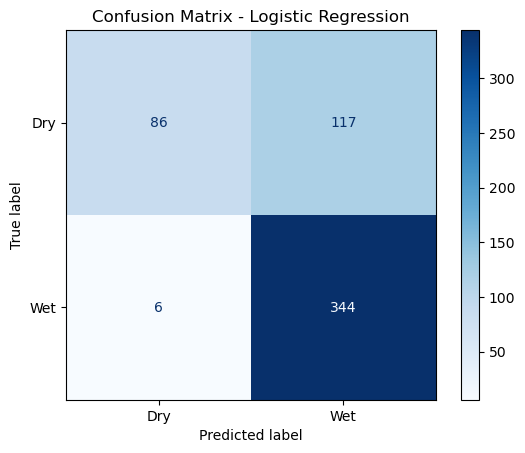

In [19]:
#Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dry', 'Wet'])
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [20]:
#Make feature importances table (coefficients)
feature_cols = X_train.columns.tolist()

coefficients = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": LR_model.coef_[0]
})

#Sort by absolute value to see most important features
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

print(coefficients[['Feature', 'Coefficient']].to_string(index=False))

       Feature  Coefficient
         Slope    -2.449643
 aspect_se_pct     2.413662
 aspect_ne_pct    -2.248776
          srad     1.468213
          tmax    -1.349206
         rhmax    -1.256667
         value     1.165001
      FromNode     0.837862
           sph     0.760790
      AreaSqKm     0.723268
     In-degree     0.687111
slp_median_pct     0.541256
   curv_median     0.541256
          prcp    -0.503711
     curv_mean     0.501331
  slp_mean_pct     0.501331
         rhmin     0.461578
            ws     0.449965
  elev_mean_cm    -0.405273
   elev_min_cm    -0.404196
    ArbolateSu    -0.402247
 aspect_nw_pct     0.395553
     etalfalfa    -0.387905
elev_median_cm    -0.347581
        ToNode     0.315937
          tmin    -0.260010
   elev_max_cm    -0.207276
 aspect_sw_pct    -0.203227
      LengthKM     0.161353
            vp     0.106205
       etgrass    -0.048505
     TotDASqKm     0.014055
    Out-degree     0.000000


## Inference

In [21]:
def predict_site_date(model, scaler, central_df, feature_cols, site_id, date):
    """
    Predict wet/dry status for a given site and date.
    
    Parameters:
    -----------
    model : LogisticRegression
        Trained logistic regression model
    scaler : StandardScaler
        Fitted scaler for feature normalization
    central_df : pd.DataFrame
        Complete dataset with all features
    feature_cols : list
        List of feature column names used in training
    site_id : str
        Site identifier (e.g., "HoboSite100")
    date : str
        Date in format "YYYY-MM-DD"
    
    Returns:
    --------
    str : Prediction result with probability
    """
    date = pd.to_datetime(date)
    site_id = str(site_id)
    
    row = central_df[(central_df["SiteIDCode"] == site_id) & (central_df["Date"] == date)]
    
    if row.empty:
        return f"No data found for Site {site_id} on {date.date()}"
    
    Xq = row[feature_cols]
    Xq_scaled = scaler.transform(Xq)
    
    pred_class = model.predict(Xq_scaled)
    pred_prob = model.predict_proba(Xq_scaled)[:, 1]
    
    return f"Site {site_id} on {date.date()}: {'DRY' if pred_class == 0 else 'WET'}, (P(wet)={pred_prob[0]:.4f})"

In [22]:
#Example inference
predict_site_date(
    model=LR_model,
    scaler=scaler,
    central_df=central_df,
    feature_cols=feature_cols,
    site_id="HoboSite100",
    date="2020-10-22"
)

'Site HoboSite100 on 2020-10-22: DRY, (P(wet)=0.0165)'